## DeepEdit Inference Tutorial

DeepEdit is an algorithm that combines the power of two models in one single architecture. It allows the user to perform inference, as a standard segmentation method (i.e. UNet), and also to interactively segment part of an image using clicks (Sakinis et al.). DeepEdit aims to facilitate the user experience and at the same time the development of new active learning techniques.


This Notebooks shows the performance of a model trained to segment the spleen. 

**We recommend importing the pretrained model into the [DeepEdit App in MONAI Label](https://github.com/Project-MONAI/MONAILabel/tree/main/sample-apps/radiology#deepedit) for full experience.**

Sakinis et al., Interactive segmentation of medical images through fully convolutional neural networks. (2019) https://arxiv.org/abs/1903.08205

In [1]:
# !python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

#### Using library versions:

monai==0.8.1 nibabel==3.2.2 numpy==1.22.3 pytorch-ignite==0.4.8 scikit-image==0.19.2 scipy==1.8.0 tensorboard==2.8.0 torch==1.11.0 tqdm==4.64.0


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import jit

import monai

from custom_transforms import (
    AddGuidanceSignalCustomd,
    AddGuidanceFromPointsCustomd,
    AddRandomGuidanceCustomd,
    FindDiscrepancyRegionsCustomd,
    ResizeGuidanceMultipleLabelCustomd,
    NormalizeLabelsInDatasetd,
    FindAllValidSlicesMissingLabelsd,
    AddInitialSeedPointMissingLabelsd,
)


from monai.transforms import (
    Activationsd,
    AddChanneld,
    AsChannelFirstd,
    AsDiscreted,
    Compose,
    EnsureTyped,
    LoadImaged,
    Orientationd,
    Resized,
    ScaleIntensityRanged,
    SqueezeDimd,
    ToNumpyd,
    ToTensord,
)


def draw_points(guidance, slice_idx):
    if guidance is None:
        return
    for p in guidance:
        p1 = p[1]
        p2 = p[0]
        plt.plot(p1, p2, "r+", 'MarkerSize', 30)


def show_image(image, label, guidance=None, slice_idx=None):
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")

    if label is not None:
        masked = np.ma.masked_where(label == 0, label)
        plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)

    draw_points(guidance, slice_idx)
    plt.colorbar()

    if label is not None:
        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(label)
        plt.colorbar()
        # draw_points(guidance, slice_idx)
    plt.show()


def print_data(data):
    for k in data:
        v = data[k]

        d = type(v)
        if type(v) in (int, float, bool, str, dict, tuple):
            d = v
        elif hasattr(v, 'shape'):
            d = v.shape

        if k in ('image_meta_dict', 'label_meta_dict'):
            for m in data[k]:
                print('{} Meta:: {} => {}'.format(k, m, data[k][m]))
        else:
            print('Data key: {} = {}'.format(k, d))

In [3]:
# Download data and model

resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/_image.nii.gz"
dst = "_image.nii.gz"

if not os.path.exists(dst):
    monai.apps.download_url(resource, dst)

resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/pretrained_deepedit_dynunet-final.ts"
dst = "pretrained_deepedit_dynunet-final.ts"
if not os.path.exists(dst):
    monai.apps.download_url(resource, dst)

_image.nii.gz: 29.5MB [00:03, 8.43MB/s]                                                                                                                                                                    

2022-04-18 20:09:38,670 - INFO - Downloaded: _image.nii.gz
2022-04-18 20:09:38,670 - INFO - Expected md5 is None, skip md5 check for file _image.nii.gz.



pretrained_deepedit_dynunet-final.ts: 118MB [00:14, 8.78MB/s]                                                                                                                                              

2022-04-18 20:09:52,819 - INFO - Downloaded: pretrained_deepedit_dynunet-final.ts
2022-04-18 20:09:52,819 - INFO - Expected md5 is None, skip md5 check for file pretrained_deepedit_dynunet-final.ts.


LoadImaged => image shape: (392, 392, 210)


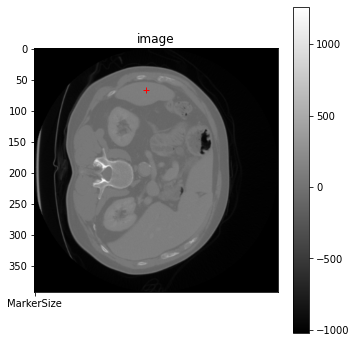

AddChanneld => image shape: (1, 392, 392, 210)
Orientationd => image shape: (1, 392, 392, 210)
ScaleIntensityRanged => image shape: (1, 392, 392, 210)
AddGuidanceFromPointsCustomd => image shape: (1, 392, 392, 210)
Resized => image shape: (1, 128, 128, 128)
ResizeGuidanceMultipleLabelCustomd => image shape: (1, 128, 128, 128)
AddGuidanceSignalCustomd => image shape: (3, 128, 128, 128)
ToTensord => image shape: torch.Size([3, 128, 128, 128])


In [4]:
# labels
labels = {'spleen': 1,
          'background': 0
          }

# Pre Processing
spatial_size = [128, 128, 128]

data = {
    'image': '_image.nii.gz',
    'guidance': {'spleen': [[66, 180, 105], [66, 180, 145]], 'background': []},
}

slice_idx = original_slice_idx = data['guidance']['spleen'][0][2]

pre_transforms = [
                LoadImaged(keys="image", reader="ITKReader"),
                AddChanneld(keys="image"),
                Orientationd(keys="image", axcodes="RAS"),
                ScaleIntensityRanged(keys="image", a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
                AddGuidanceFromPointsCustomd(ref_image="image", guidance="guidance", label_names=labels),
                Resized(keys="image", spatial_size=spatial_size, mode="area"),
                ResizeGuidanceMultipleLabelCustomd(guidance="guidance", ref_image="image"),
                AddGuidanceSignalCustomd(keys="image", guidance="guidance"),
                ToTensord(keys="image"),
                ]

original_image = None

# Going through each of the pre_transforms
for t in pre_transforms:
    
    tname = type(t).__name__
    data = t(data)         
    image = data['image']
    label = data.get('label')
    guidance = data.get('guidance')

    print("{} => image shape: {}".format(tname, image.shape))
    
    if tname == 'LoadImaged':
        original_image = data['image']
        label = None
        tmp_image = image[:, :, slice_idx]    
        show_image(tmp_image, label, [guidance['spleen'][0]], slice_idx)
        
        
transformed_image = data['image']
guidance = data.get('guidance')

EnsureTyped => image shape: torch.Size([3, 128, 128, 128]), pred shape: torch.Size([2, 128, 128, 128])
Activationsd => image shape: torch.Size([3, 128, 128, 128]), pred shape: torch.Size([2, 128, 128, 128])
AsDiscreted => image shape: torch.Size([3, 128, 128, 128]), pred shape: torch.Size([1, 128, 128, 128])
SqueezeDimd => image shape: torch.Size([3, 128, 128, 128]), pred shape: torch.Size([128, 128, 128])
ToNumpyd => image shape: torch.Size([3, 128, 128, 128]), pred shape: (128, 128, 128)
Final PLOT:: 50 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 16.0


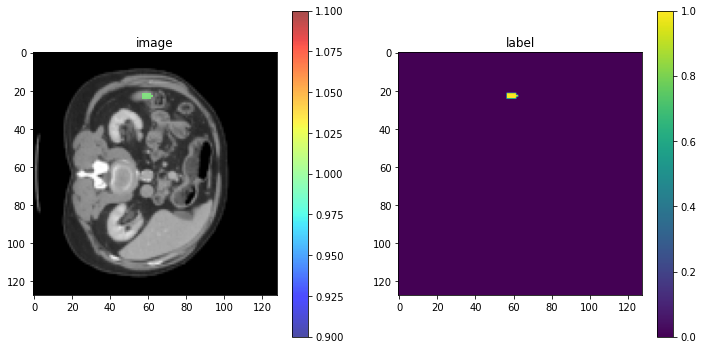

Final PLOT:: 51 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 45.0


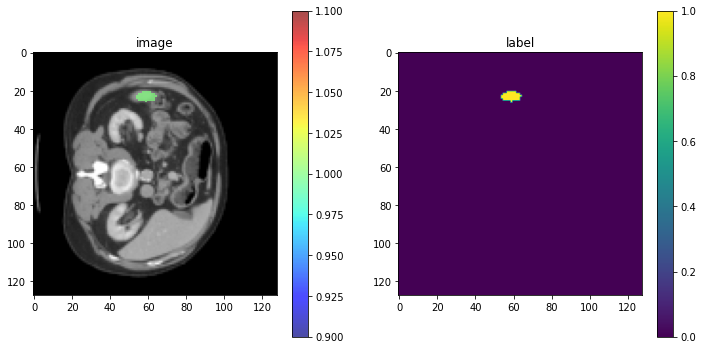

Final PLOT:: 52 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 72.0


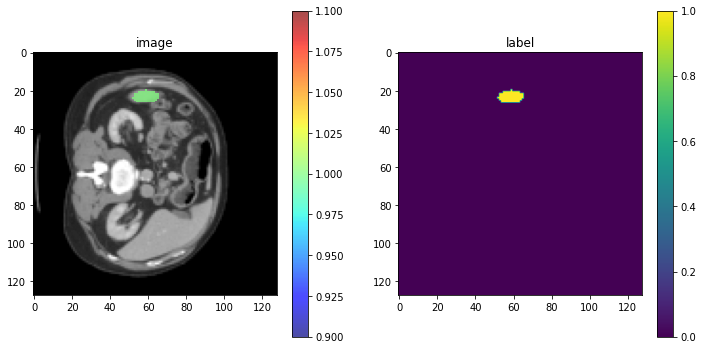

Final PLOT:: 53 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 103.0


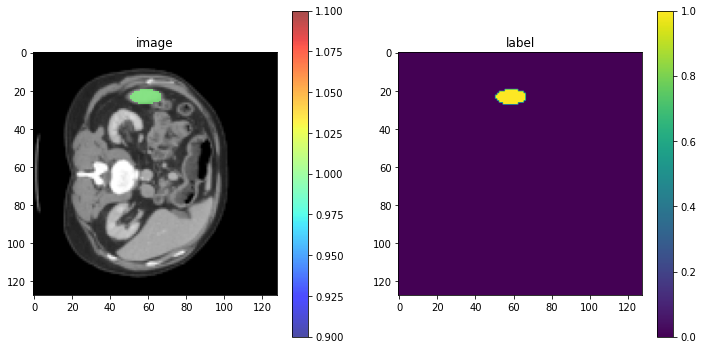

Final PLOT:: 54 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 121.0


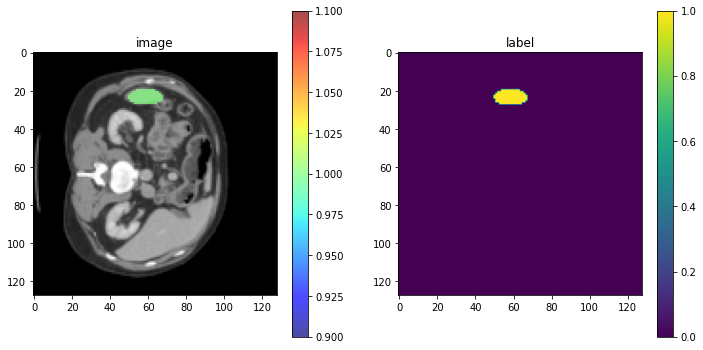

Final PLOT:: 55 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 138.0


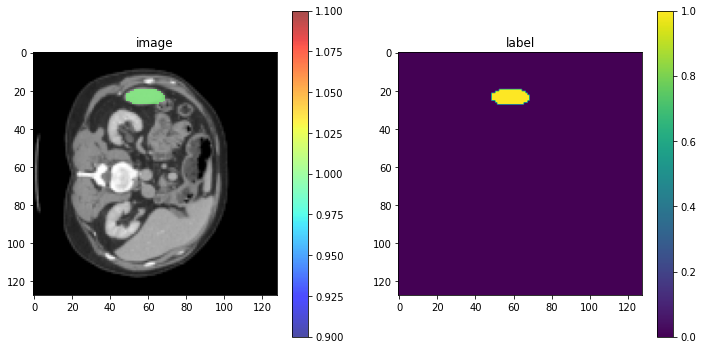

Final PLOT:: 56 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 162.0


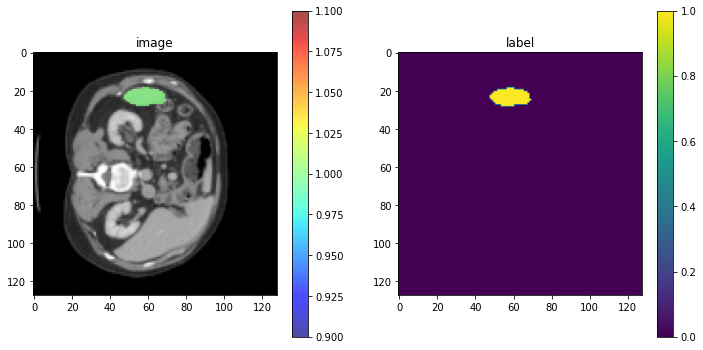

Final PLOT:: 57 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 180.0


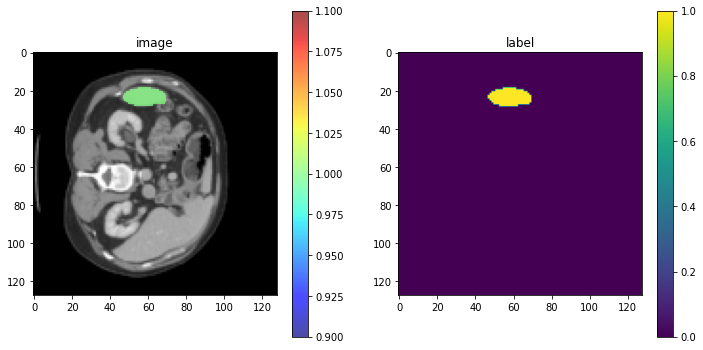

Final PLOT:: 58 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 196.0


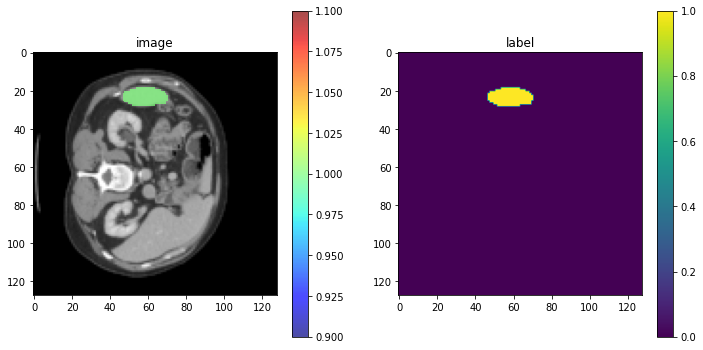

Final PLOT:: 59 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 214.0


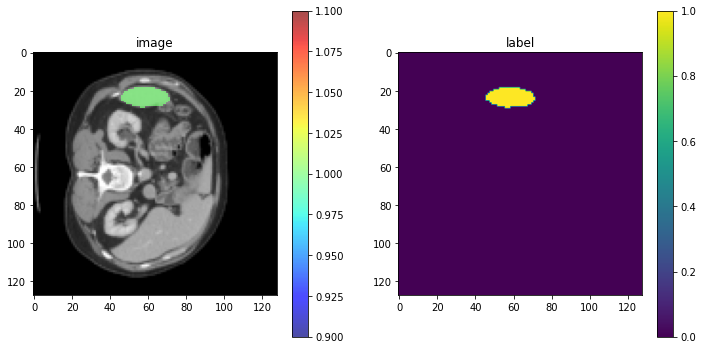

Final PLOT:: 60 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 228.0


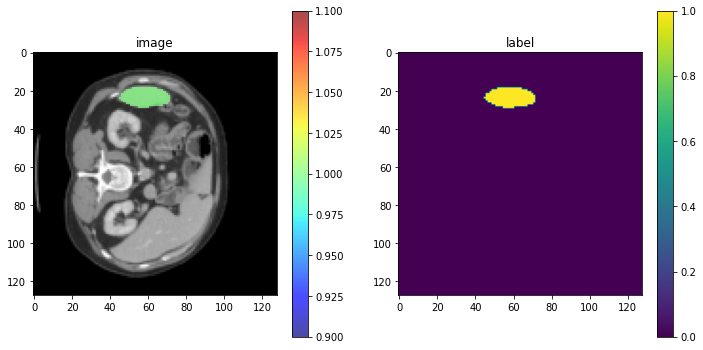

Final PLOT:: 61 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 243.0


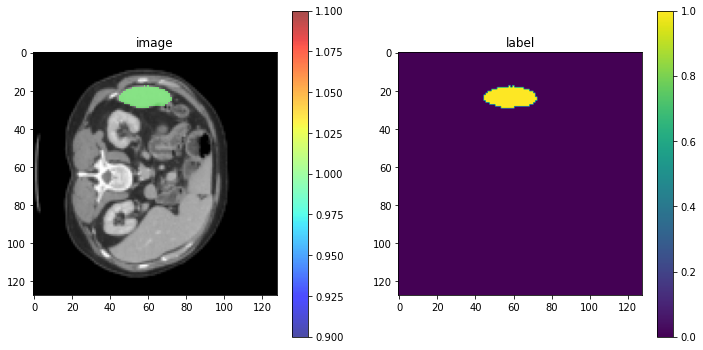

Final PLOT:: 62 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 249.0


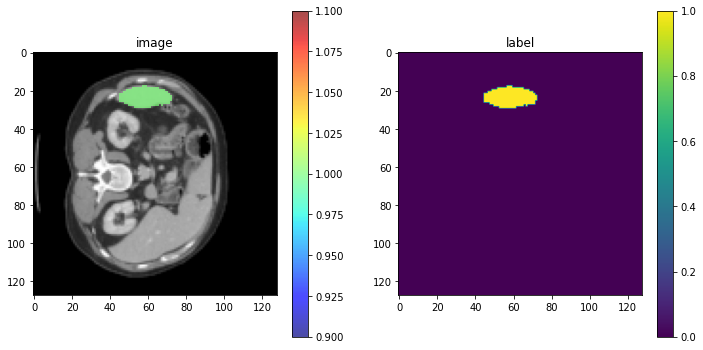

Final PLOT:: 63 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 264.0


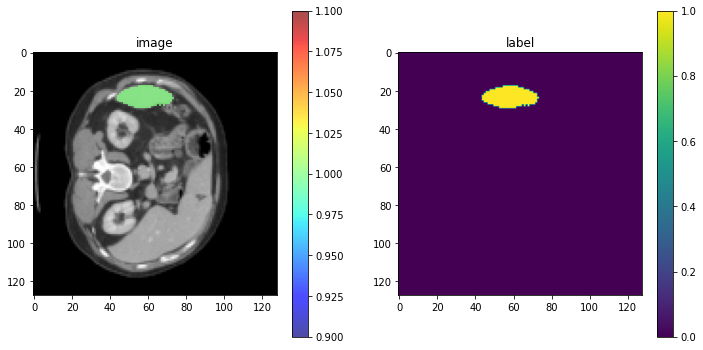

Final PLOT:: 64 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 272.0


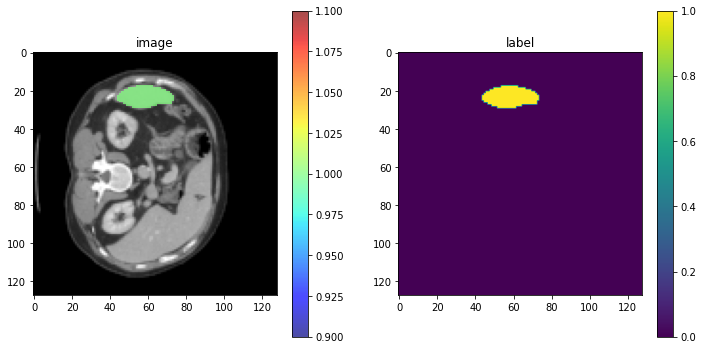

Final PLOT:: 65 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 284.0


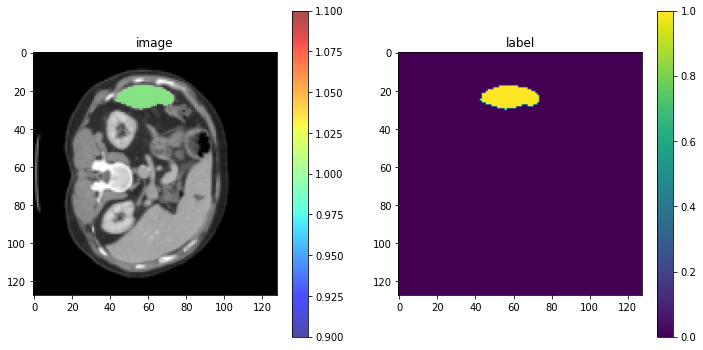

Final PLOT:: 66 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 296.0


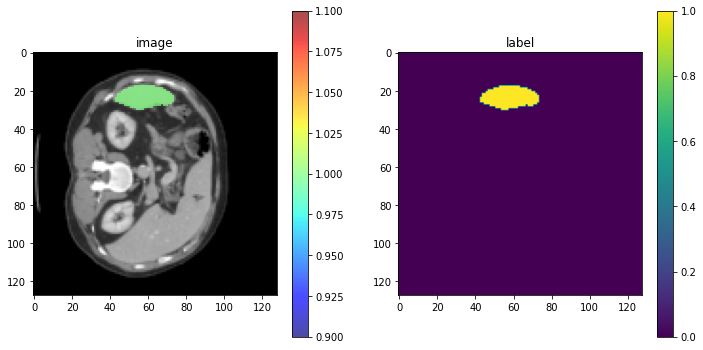

Final PLOT:: 67 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 308.0


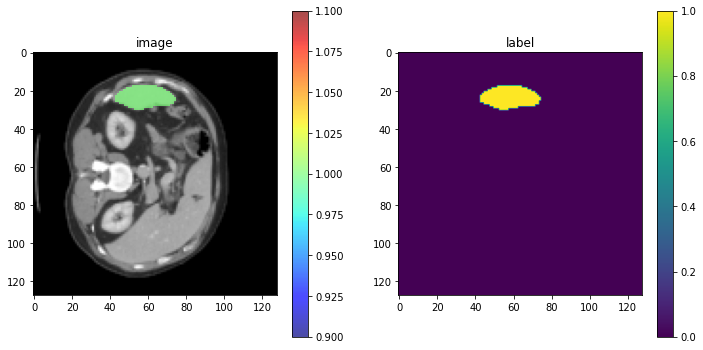

Final PLOT:: 68 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 315.0


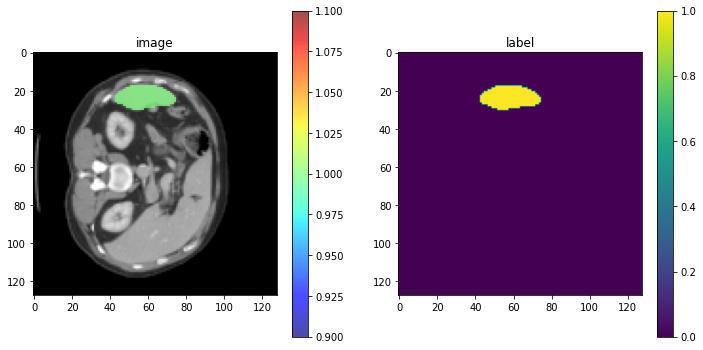

Final PLOT:: 69 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 328.0


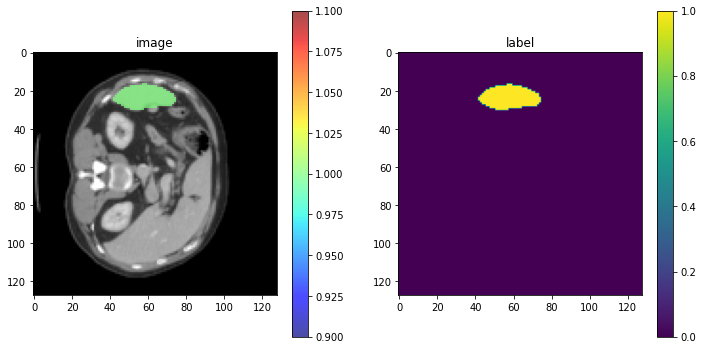

Final PLOT:: 70 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 343.0


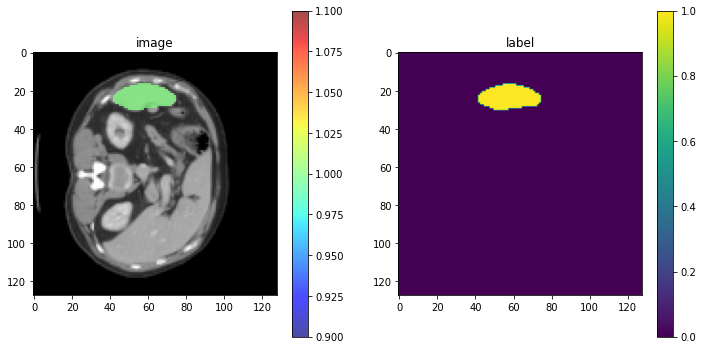

Final PLOT:: 71 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 356.0


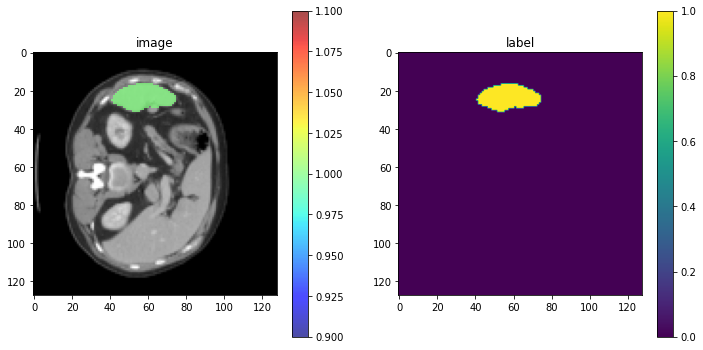

Final PLOT:: 72 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 365.0


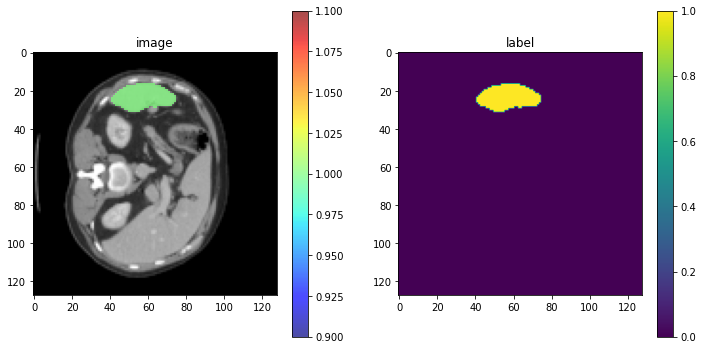

Final PLOT:: 73 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 371.0


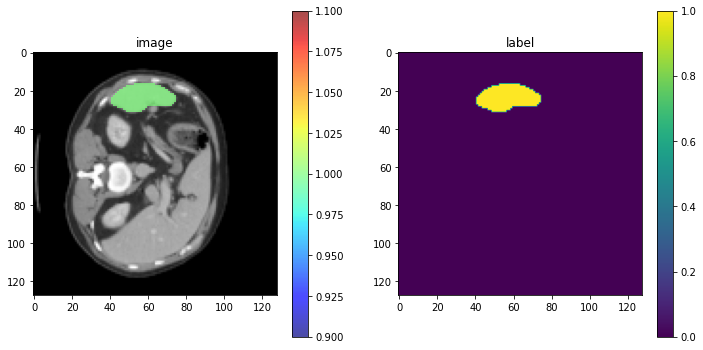

Final PLOT:: 74 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 377.0


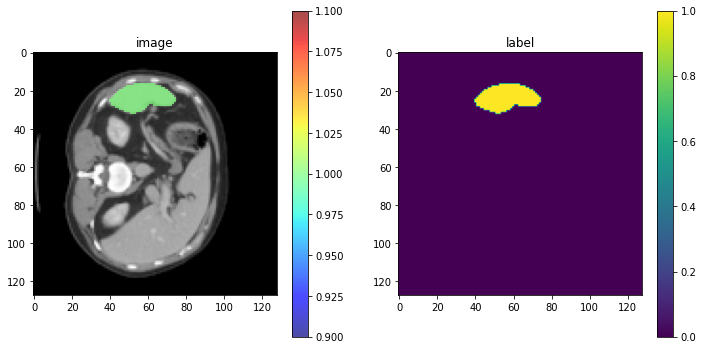

Final PLOT:: 75 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 384.0


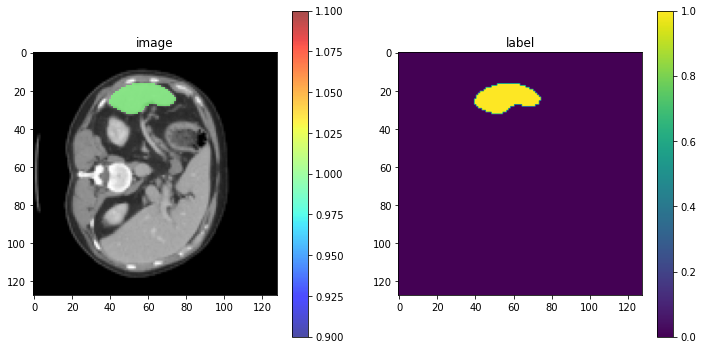

Final PLOT:: 76 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 387.0


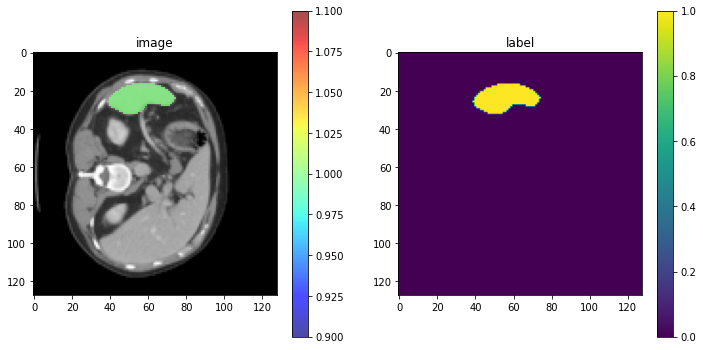

Final PLOT:: 77 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 390.0


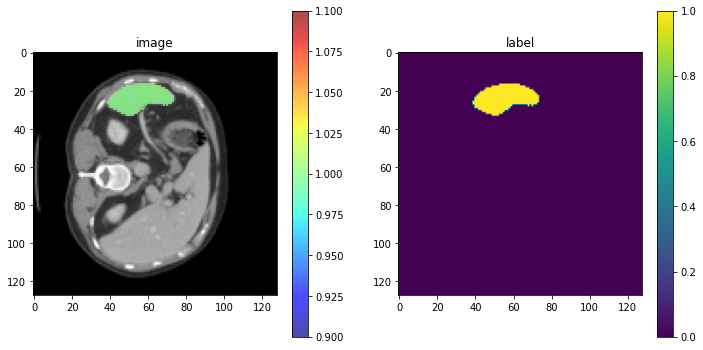

Final PLOT:: 78 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 394.0


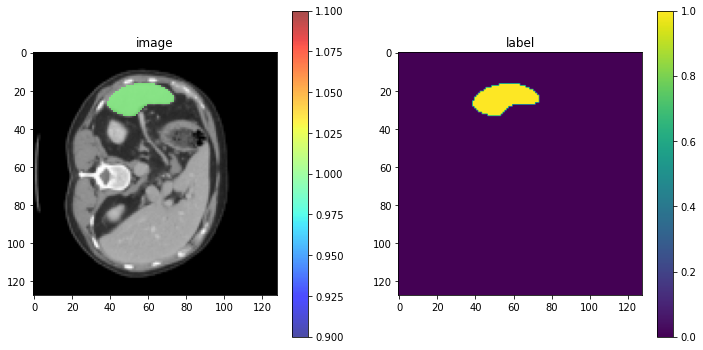

Final PLOT:: 79 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 402.0


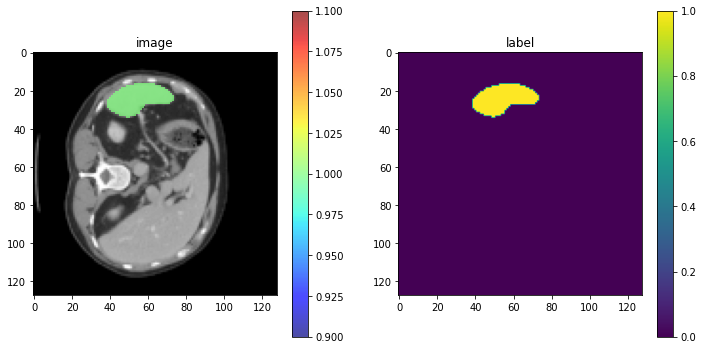

Final PLOT:: 80 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 410.0


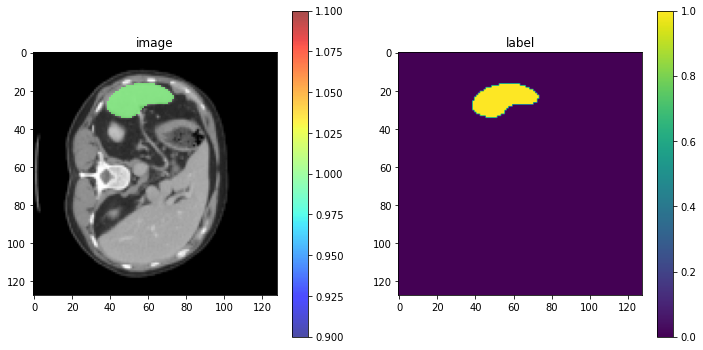

Final PLOT:: 81 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 413.0


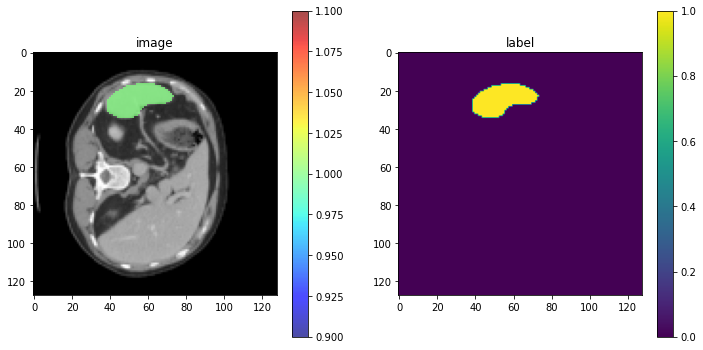

Final PLOT:: 82 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 414.0


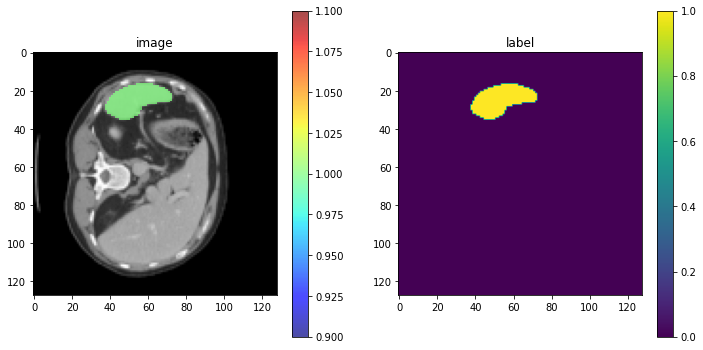

Final PLOT:: 83 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 419.0


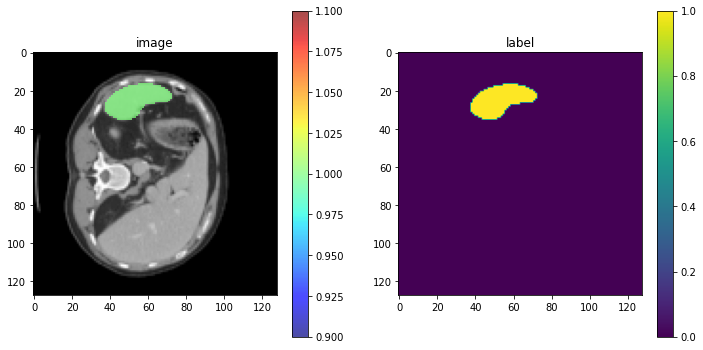

Final PLOT:: 84 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 416.0


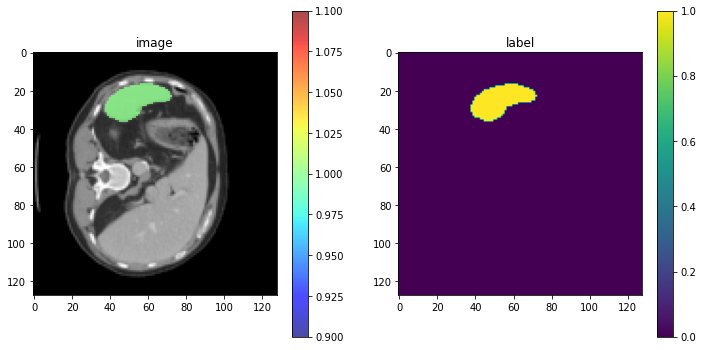

Final PLOT:: 85 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 406.0


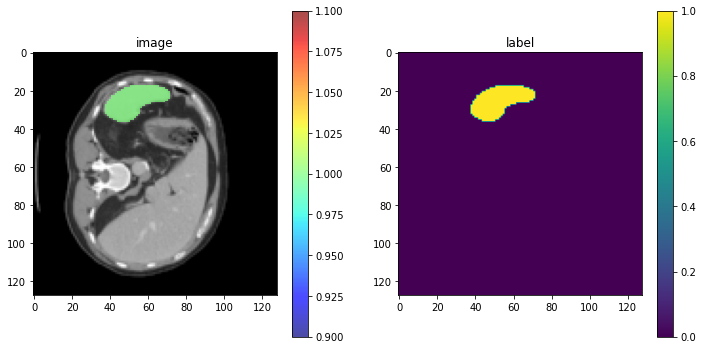

Final PLOT:: 86 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 405.0


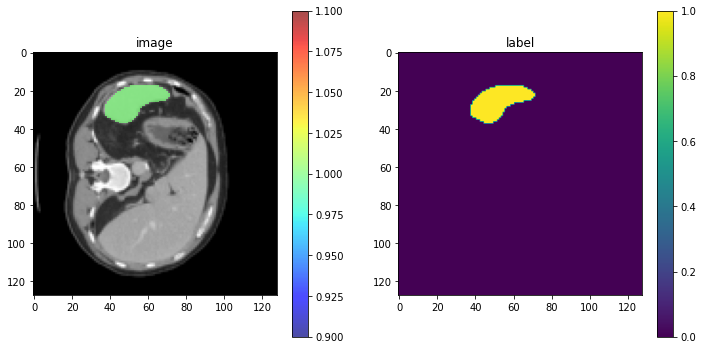

Final PLOT:: 87 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 404.0


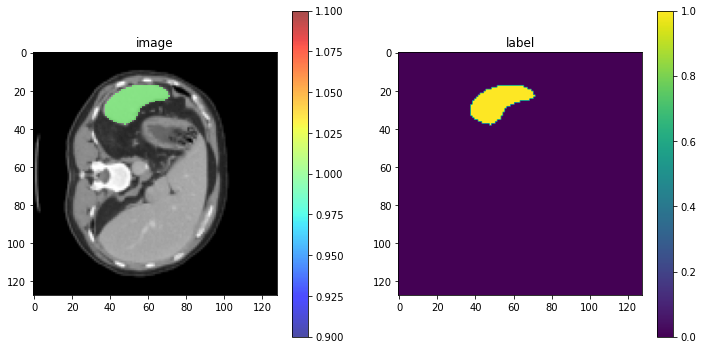

Final PLOT:: 88 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 403.0


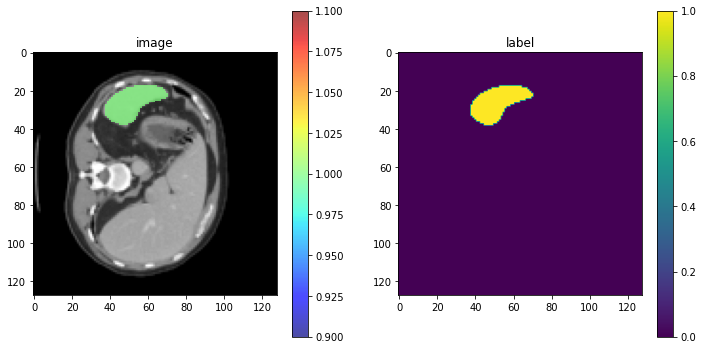

Final PLOT:: 89 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 399.0


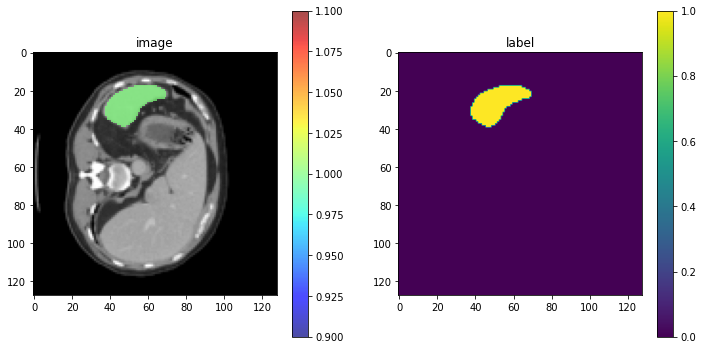

Final PLOT:: 90 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 394.0


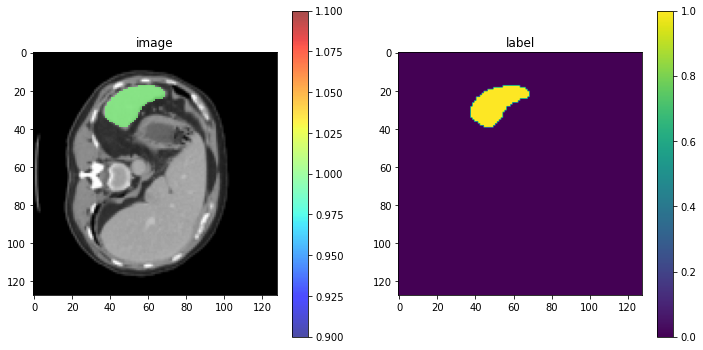

Final PLOT:: 91 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 388.0


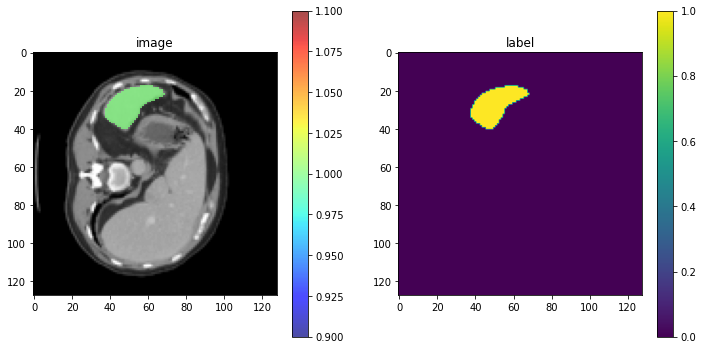

Final PLOT:: 92 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 384.0


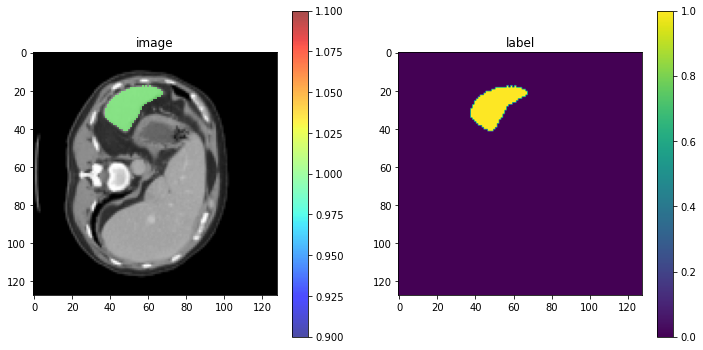

Final PLOT:: 93 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 372.0


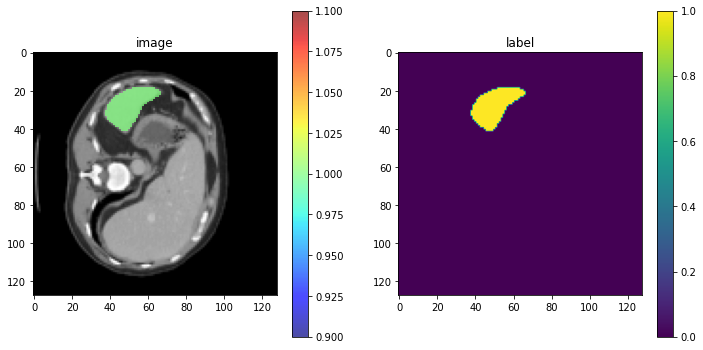

Final PLOT:: 94 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 371.0


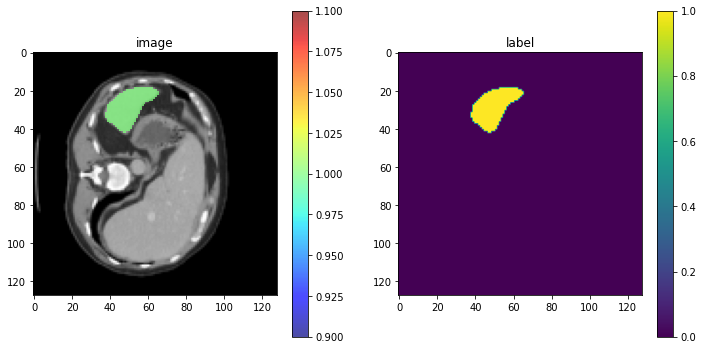

Final PLOT:: 95 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 369.0


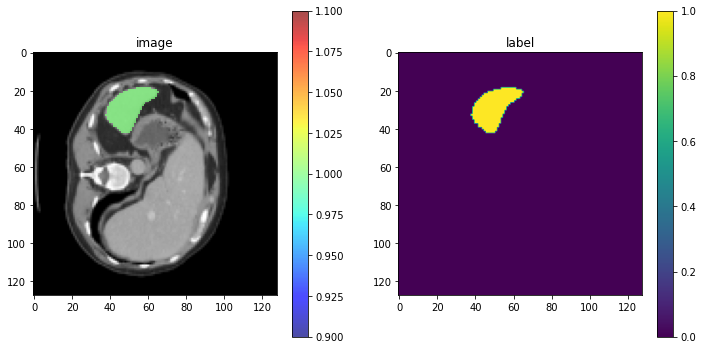

Final PLOT:: 96 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 366.0


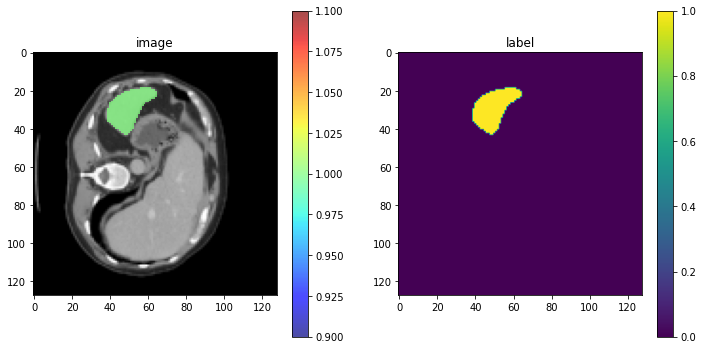

Final PLOT:: 97 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 366.0


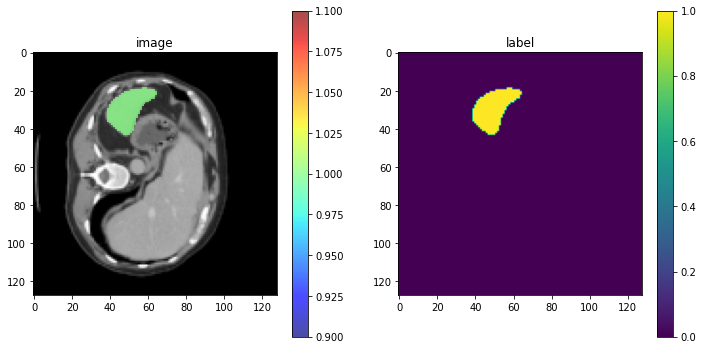

Final PLOT:: 98 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 357.0


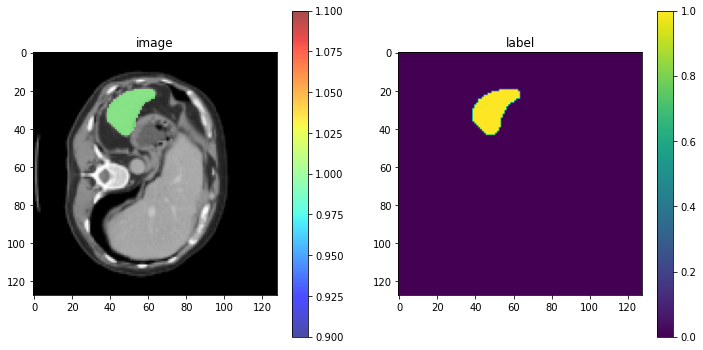

Final PLOT:: 99 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 356.0


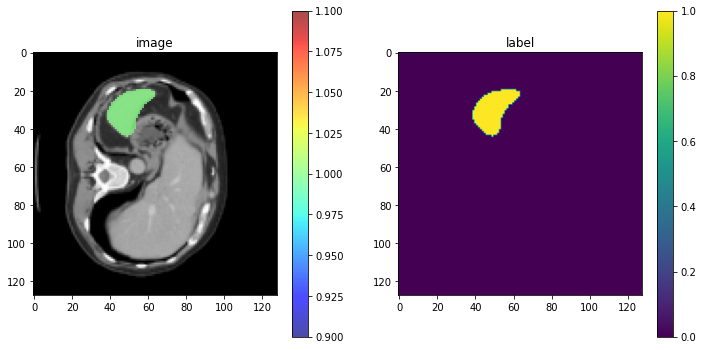

Final PLOT:: 100 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 358.0


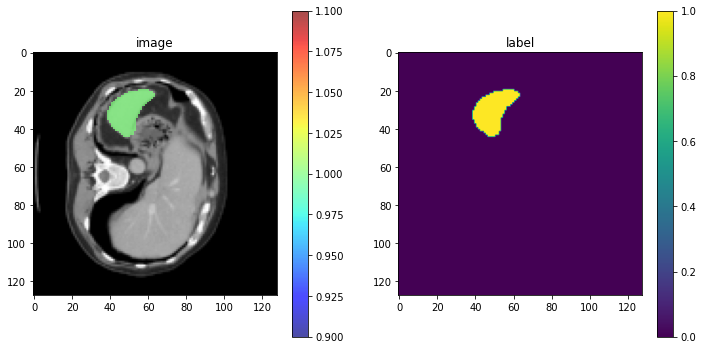

Final PLOT:: 101 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 355.0


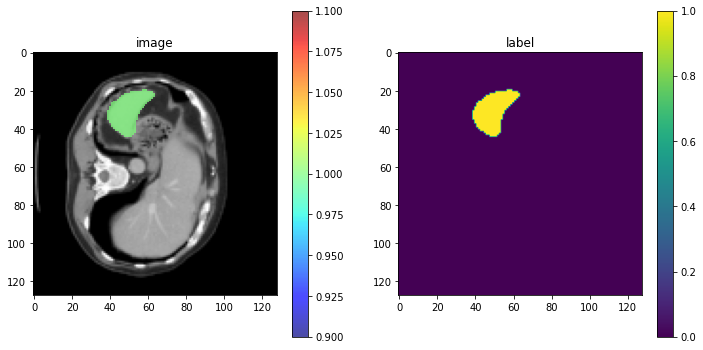

Final PLOT:: 102 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 346.0


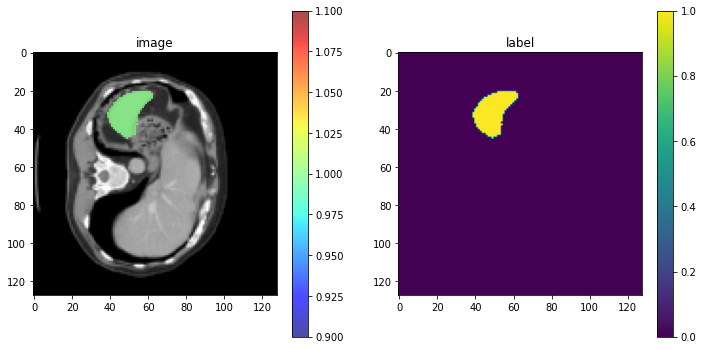

Final PLOT:: 103 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 338.0


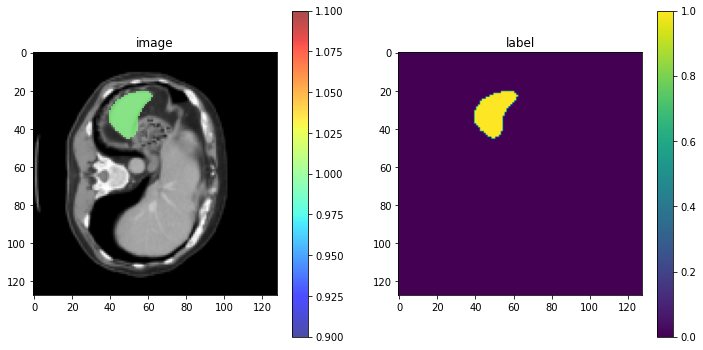

Final PLOT:: 104 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 330.0


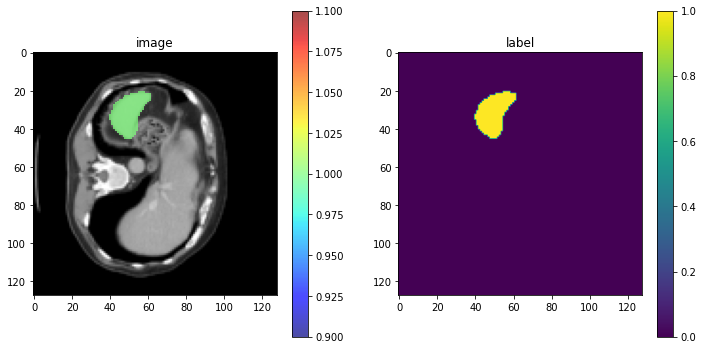

Final PLOT:: 105 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 308.0


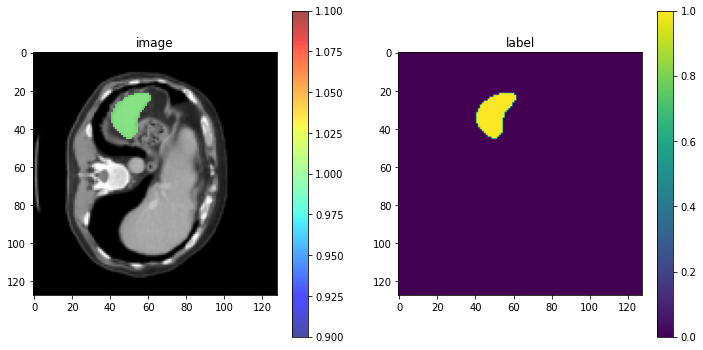

Final PLOT:: 106 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 296.0


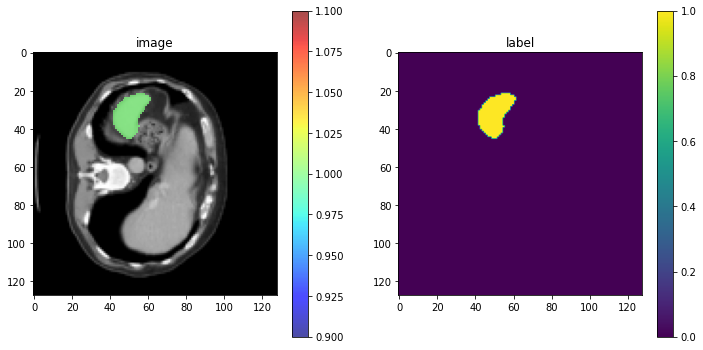

Final PLOT:: 107 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 274.0


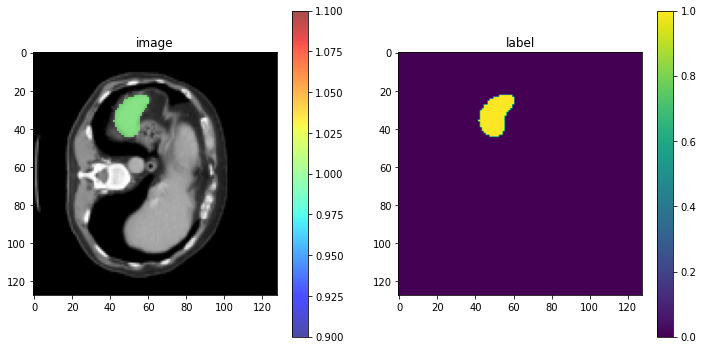

Final PLOT:: 108 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 253.0


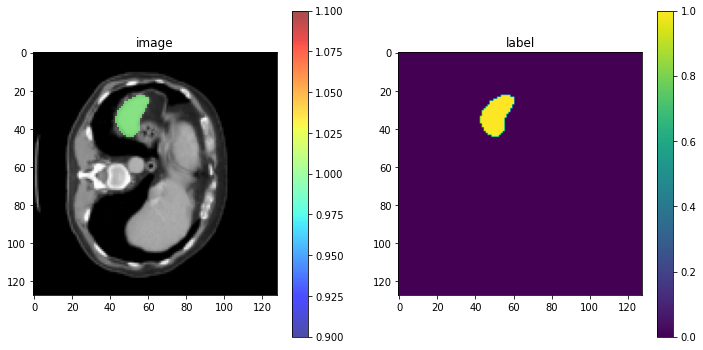

Final PLOT:: 109 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 219.0


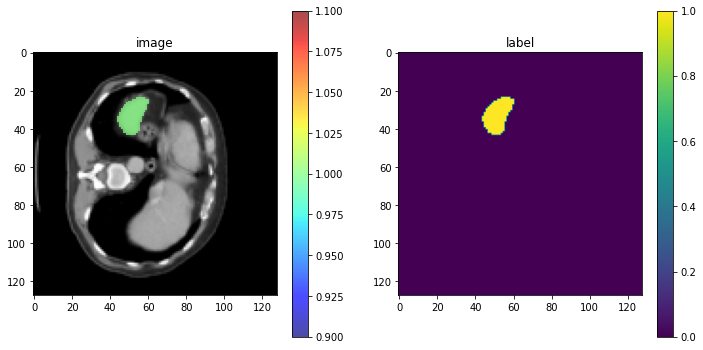

Final PLOT:: 110 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 191.0


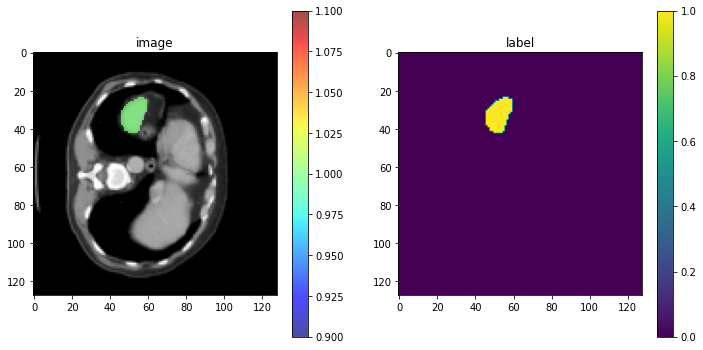

Final PLOT:: 111 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 157.0


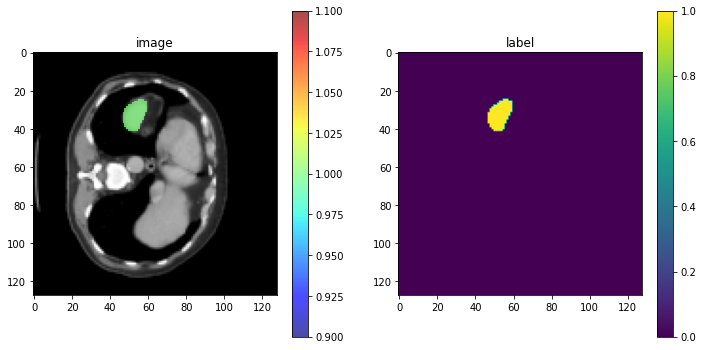

Final PLOT:: 112 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 121.0


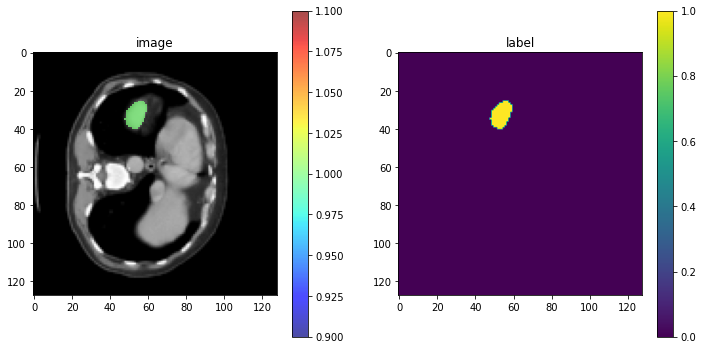

Final PLOT:: 113 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 78.0


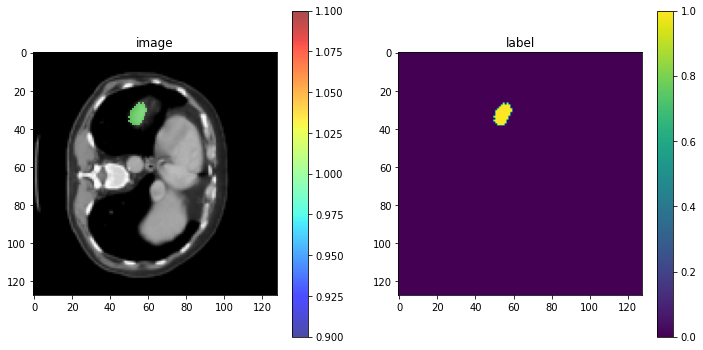

Final PLOT:: 114 => image shape: torch.Size([128, 128]), pred shape: (128, 128); min: 0.0, max: 1.0, sum: 23.0


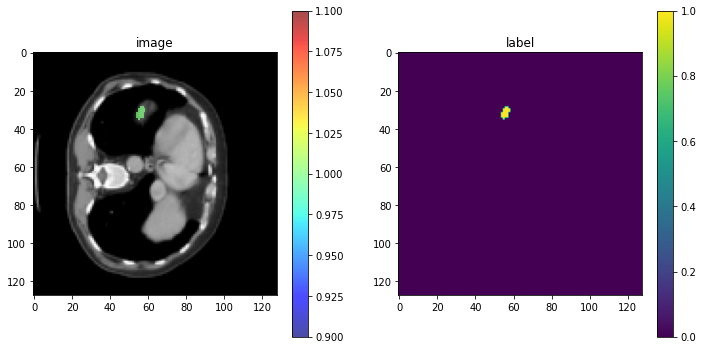

In [5]:
# Evaluation
model_path = 'pretrained_deepedit_dynunet-final.ts'
model = jit.load(model_path)
model.cuda()
model.eval()

inputs = data['image'][None].cuda()
with torch.no_grad():
    outputs = model(inputs)
outputs = outputs[0]
data['pred'] = outputs

post_transforms = [
                    EnsureTyped(keys="pred"),
                    Activationsd(keys="pred", softmax=True),
                    AsDiscreted(keys="pred", argmax=True),
                    SqueezeDimd(keys="pred", dim=0),
                    ToNumpyd(keys="pred"),
]

pred = None
for t in post_transforms:
    
    tname = type(t).__name__
    data = t(data)
    image = data['image']
    label = data['pred']
    print("{} => image shape: {}, pred shape: {}".format(tname, image.shape, label.shape))
    
for i in range(data['pred'].shape[0]):
    image = transformed_image[0, :, :, i] # Taking the first channel which is the main image
    label = data['pred'][:, :, i]
    if np.sum(label) == 0:
        continue

    print("Final PLOT:: {} => image shape: {}, pred shape: {}; min: {}, max: {}, sum: {}".format(
        i, image.shape, label.shape, np.min(label), np.max(label), np.sum(label)))
    show_image(image, label)

In [6]:
# remove downloaded files
os.remove('_image.nii.gz')
os.remove('pretrained_deepedit_dynunet-final.ts')